# Домашнее задание 3

# 1. Введение.

В этом разделе нам необходимо построить прогнозные модели для курсов валют. На семинарах мы обсуждали, что прогнозировать цены котировок стандартными линейными моделями довольно бесперспективно. Так как такие данные близки к модели случайного блуждания, оптимальным прогнозом для них часто оказывается наивный. Однако если перейти к более низкой частоте (например, к месячным данным), то некоторого превосходства над наивной всё же можно добиться.

В приложенном датасете currencies.csv находятся следующие величины:
1.  Курсы ряда валют по отношению к доллару. 

    Курс EUR/USD - Евро Доллар США
    
    Курс CNY/USD - Китайский юань Доллар США
    
    Курс INR/USD - Индийская рупия Доллар США
    
    Курс JPY/USD - Японская йена Доллар США
    
    Курс GBR/USD - Британский фунт Доллар США
    
    Курс CHF/USD - Швейцарский франк Доллар США
    
    Курс BRL/USD - Бразильский реал Доллар США
    
    Курс IDR/USD - Индонезийская рупия Доллар США

2. Цена нефти BRENT за баррель и цена газа в Европе за mmbtu (Британская тепловая единица)
3. ff_rate -- ставка ФРС США

Нашей задачей будет построить прогнозную модель для всех курсов валют из пункта 1. Цены нефти, газа и ставка ФРС даны дополнительно, можете использовать их если посчитаете необходимым, но в базовой версии можно использовать только временные ряды курсов валют.

### Импорт данных

Импортируйте данные из файла. Приведите информацию о датах в один столбец типа datetime. Например, чтобы каждая точка отображала дату начала месяца. 

In [27]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/vsevolodparamonov/Downloads/currencies.csv', sep=';')
df = df.replace(',', '.', regex=True)

df['Месяц'] = df['Месяц'].apply(lambda x: '0' + str(x) if x < 10 else x)

df['date'] = pd.to_datetime(df['Год'].astype(str) + '-01-' + df['Месяц'].astype(str))

df[df.columns[2:-1]] = df[df.columns[2:-1]].astype(float)
df

,Год,Квартал,Месяц,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate,date
0,2000,1,1.0,25.3800,3.360000,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137,5.45,2000-01-01
1,2000,1,2.0,27.7048,3.460000,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135,5.73,2000-01-02
2,2000,1,3.0,27.4700,3.510000,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134,5.85,2000-01-03
3,2000,2,4.0,22.5400,3.680000,0.945325,0.120783,0.022347,0.946392,1.581220,0.601190,0.565205,0.000128,6.02,2000-01-04
4,2000,2,5.0,27.3400,3.550000,0.908461,0.120801,0.022323,0.924374,1.509061,0.583104,0.547661,0.000120,6.27,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,2023,1,3.0,78.5300,13.812077,1.071061,0.145039,0.012120,0.748226,1.214527,1.080700,0.192174,0.000065,4.65,2023-01-03
279,2023,2,4.0,84.1100,13.520530,1.096370,0.145155,0.012110,0.749125,1.245177,1.113580,0.199370,0.000067,4.83,2023-01-04
280,2023,2,5.0,75.7000,10.108756,1.086113,0.143078,0.012118,0.728717,1.248080,1.114409,0.200783,0.000067,5.06,2023-01-05
281,2023,2,6.0,74.8900,10.350625,1.084395,0.139595,0.012094,0.707077,1.263834,1.111168,0.206236,0.000067,5.08,2023-01-06


Писать для каждого ряда одномерную модель несколько расточительно, хотя и не лишено смысла. Этот процесс необходимо автоматизировать. В простом для понимания варианте можно свести прогноз каждой валюты к табличной задаче и подобрать регрессоры из остальных рядов. Мы таким уже занимались, поэтому попробуем зайти с немного другой стороны.

Весь рынок и в частности рынок валют -- единый механизм, находящийся в некотором равновесии и иногда от него отклоняющийся. Значит, у рядов должен быть общий тренд. Формально такая ситуация называется коинтеграцией и это тема отдельной лекции, нам она будет нужна только для идеи. Более подробно про коинтеграцию можно почитать вот в этом [конспекте](https://vk.com/doc126754362_567660819?hash=AvDGHaO92KX7exjBCleLZsEGHPPX2iZfCqae2Fijkng). 

### 1. (0.5 балла) Визуализация

Давайте увидим это явно. Возьмите все курсы валют, отнормируйте их c помощью StandardScaler из sklearn и изобразите результат на одном графике. 

График будет немного шумный, но вы должны заметить что в целом валюты движутся по схожим траекториям, а некоторые группируются.

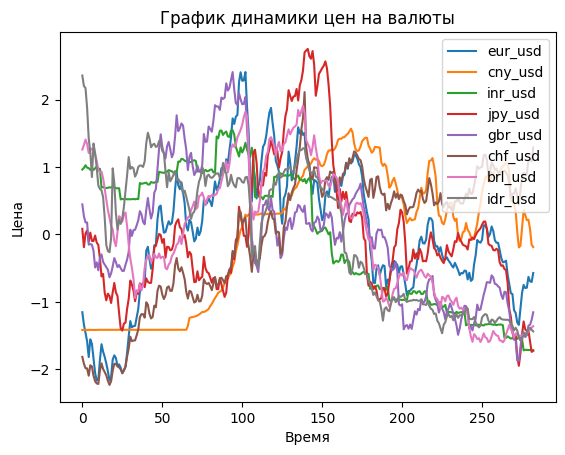

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feats = 'brent	gas	eur_usd	cny_usd	inr_usd	jpy_usd	gbr_usd	chf_usd	brl_usd	idr_usd	ff_rate'.split('\t')

df_scaled = df.copy()

df_scaled.loc[:, feats] = scaler.fit_transform(df_scaled.loc[:, feats])
df_scaled.set_index('date', inplace=True)

currency = 'eur_usd	cny_usd	inr_usd	jpy_usd	gbr_usd	chf_usd	brl_usd	idr_usd'.split('\t')

for cur in currency:

    plt.plot(df_scaled[cur].values, label=cur)

plt.xlabel('Время')
plt.ylabel('Цена')
plt.title('График динамики цен на валюты')
plt.legend();

Можно ли выделить эти общие тренды на рынке? Да! Можно просто рассмотреть все валюты как один многомерный вектор и понизить его размерность.

Конечно, для временных рядов существуют специфические методы понижения размерности, но они выходят за рамки нашего курса. Поэтому мы воспользуемся не слишком подходящим, но зато простым и знакомым методом главных компонент (PCA). PCA никак не учитывает временную зависимость точек, но мы позволим себе пренебречь этим.

### 2. (0.5 балла) Визуализация главных компонент

Примените PCA на рядах из восьми валют и отберите три первые главные компоненты. Изобразите их на одном графике. Сравните с предыдущим графиком. Компоненты будут примерно похожи на тренды нескольких разных групп валют.

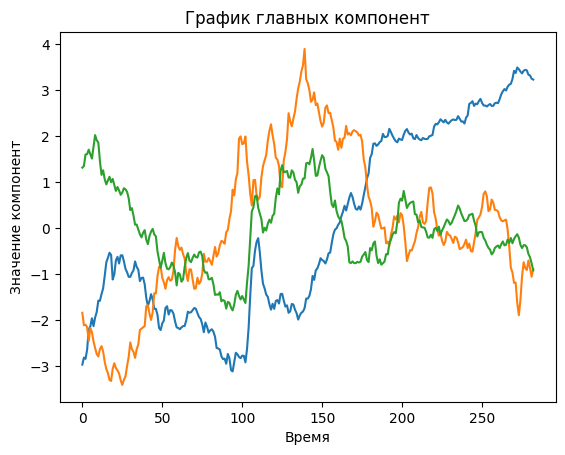

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)

df_pca = pd.DataFrame(pca.fit_transform(df_scaled[currency]))

plt.xlabel('Время')
plt.ylabel('Значение компонент')
plt.title('График главных компонент')
plt.plot(df_pca);

# 2. VAR для каждой валюты

Хочется построить какую-то общую модель, которая учтёт эти тренды на рынке и позволит с её помощью прогнозирвать отдельные валюты. Мы проходили только VAR(p) из прогнозирующих моделей, но её достаточно в большинстве случаев. Также мы обсуждали, что количество параметров в VAR(p)-модели равно 

$$n^2 p + n + \frac{n(n+1)}{2},$$

где n число уравнений системы. Данное выражение растёт квадратично по n. Значит, количество уравнений нам бы хотелось минимизировать. У нас в наличии 8 валют и ещё потенциально 3 дополнительных переменных. Это слишком много для стандартной VAR-модели, необходимо сократить размерность.

Будем для каждой валюты строить VAR(p) модель со следующими рядами: ряд этой валюты + из всех остальных рядов выделим PCA-компоненты. Дальнейшие шаги необходимо будет сделать для каждой из валют в списке, поэтому рекомендуется заранее писать код так, чтобы его было легко встроить в цикл. Например, разбивать код на функции и т.п. В качестве референса предлагается заполнить класс PartialForecaster. Это будет класс для прогнозирвоания одной валюты на основе всех остальных. Ваша реализация может отличаться, меняйте параметры или добавляйте свои методы в класс если необходимо.

1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от фичей и сохраняет их. Компоненты должны покрывать 95% дисперсии оригинальных данных. Не добавьте в вычисление PCA целевую фичу, это будет сильная утечка!

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо склеить целевую переменную и полученные главные компоненты в один датасет и обучить на этом VAR(p)-модель.

    Важное замечание. По-хорошему нужно оценивать модель на стационарных данных. Если бы мы оценивали модель методом максимального правдоподобия с ограничениями на стационарность, то ничего хорошего бы не вышло, коэффициенты бы сели на границу этого ограничения. Но так как в statsmodels (да и в целом чаще всего) модель оценивается методом наименьших квадратов и без ограничений на параметры, это можно проигнорировать в нашем случае. Для прогнозирования особой разницы не будет, но часть статистических тестов работать перестанет из-за возможных смещений в распределениях оценок параметров.

3. (0.5 балла) Реализуйте метод forecast. По сути нужно просто спрогнозировать VAR и достать из прогноза только один ряд для нужной валюты.



In [30]:
from statsmodels.tsa.api import VAR
import pandas as pd
import numpy as np

class PartialForecaster:
    
    def __init__(self, data:pd.DataFrame, target_feature: str, p: int | None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            target_feature {str} -- Target feature of dataframe. Other features in dataframe will be regressors
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False

        assert target_feature in data.columns

        self.data = data 
        self.target_feature = target_feature
        self.p = p
        
        
    def fit_pca(self, covered_variance=0.95) -> pd.DataFrame:
        """
        fit_pca _summary_

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """

        pca = PCA()

        data_pca = pca.fit_transform(self.data.drop(self.target_feature, axis=1))

        exp_var = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= covered_variance)

        self.is_pca_fitted = True

        return pd.DataFrame(data_pca).loc[:, :exp_var + 1]



    def fit_var(self):

        """
         Fitting var on results of PCA
        """

        assert self.is_pca_fitted

        data = pd.concat([self.fit_pca(), self.data[self.target_feature].reset_index(drop=True)], axis = 1)

        self.model = VAR(data).fit(**({'maxlags': self.p} if self.p is not None else {'maxlags': 10, 'ic': 'aic'}))
        self.p = self.model.k_ar

        self.is_var_fitted = True


    def forecast(self, h: int = 12) -> pd.Series:
        """
        forecast Forecast the entire model from the end of training data h steps forward

        Keyword Arguments:
            h {int} -- Forecasting horizon (default: {1})

        Returns:
            pd.Series -- Forecast of target_feature
        """

        assert self.is_pca_fitted and self.is_var_fitted 


        data = pd.concat([self.fit_pca(), self.data[self.target_feature].reset_index(drop=True)], axis = 1)

        forecast = pd.Series(self.model.forecast(y = data.values[:,: ], steps = h)[:, -1])
        
        assert type(forecast) is pd.Series

        return forecast

5. (1 балл) Отберите параметр p и посчитайте прогнозную ошибку такого метода для каждой валюты. 

    Предлагается следующая процедура.

    1. Выбираем некоторое стартовое окно. У нас 283 точки. 36 (12*3) последних точек выделим на тестовую часть, остальное на тренировочную.
    2. На тренировочной части выбираем p по информационному критерию. В классе выше это означает p = None

    Далее попробуем получить наиболее репрезентативную оценку ошибки для такого p. Мы будем сразу считать относительную ошибку в сравнении с наивной моделью, так как на котировках часто нельзя построить статистическую модель лучше наивной. 

    1. Прогнозируем полученной моделью на 12 шагов вперёд.
    2. Считаем абсолютную ошибку прогноза (вектор длины 12)
    3. Строим наивный прогноз
    4. Считаем абсолютную ошибку наивного прогноза
    5. Считаем отношение ошибки нашего прогноза к наивной ошибке, сохраняем этот вектор длины 12
    7. Увеличиваем тренировочную выборку на 6 наблюдений. Переоцениваем всю модель на новых данных, но уже при фиксированном p. В классе выше это будет p={некоторое число}

    Повторяем эту процедуру пока не закончатся данные. При текущих параметрах получится 4 итерации. Усредняем вектора ошибок по всем итерациям. Итого получаем усреднённый вектор длины 12. Параметры можете поменять по собственным соображениям, но поясните логику.


In [31]:
def relative_score_partial(data, currency, class_func, initial_window_size: int = 247, step: int = 5, horizon: int = 12) -> pd.Series:

    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        horizon {int} -- Forecasting horizon of cross-validation score
        p {int} -- order of VAR model
    Returns:
        pd.Series -- Vector of absolute error by each horizon, averaged by several folds
    """

    start_point = 0
    losses = np.zeros(12)

    iws_fixed = initial_window_size
    p = None

    while initial_window_size <= data.shape[0] - 12:

        df_train, df_test = data.iloc[start_point:initial_window_size, :], data.iloc[initial_window_size:, :]

        pf = class_func(df_train, currency, p)
        pf.fit_pca()
        pf.fit_var()

        p = pf.model.k_ar

        naive_loss = abs(np.full(12, df_train[currency].values[-1]) - df_test.iloc[:12][currency].values)
        forecast_loss = abs(pf.forecast().values - df_test.iloc[:12][currency].values)

        score = forecast_loss / naive_loss

        losses = np.vstack((losses, score))

        initial_window_size += 6


    return losses.mean(axis=0)


6. (0.5 балла) Постройте линейный график скоров. Можно строить любой другой график кроме линейного, если он будет более интерпретируем. Простор для творчества!

    1.  Каждая валюта представлена линией на графике
    2.  По оси абсцисс идёт горизонт прогнозирования (от 1 до 12)
    3.  По оси ординат отношение ошибки VAR-модели к ошибке наивной модели

Получилось ли по какой-то валюте стабильно предсказывать лучше наивной на всех горизонтах. По каким валютам получилось лучше, по каким хуже?

У нас получалось, что на сильно зарегулированных экономиках (например, Китай) прогнозы близки к наивным, так как курс валюты сильнее зависит от решений партии, а не внешней обстановки. Но в целом у вас может получиться и другой результат.

In [32]:
import plotly.graph_objects as go

fig = go.Figure()

metrics_1 = pd.DataFrame()

for cur in currency:

    line = relative_score_partial(df[currency], cur, PartialForecaster)
    y = np.arange(1, len(line) + 1)

    metrics_1.loc[0, cur] = sum(line < 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=cur, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()


# 3. Автокодировщик на стероидах

Можно построить альтернативный вариант.

1. Энкодер. Строим PCA на всех валютах (и доп фичах, если хотите) сразу, выделяем главные компоненты.
2. Декодер. PCA не обратим в стандартном понимании, нельзя аналитически получить из главных компонент обратно исходные ряды. Для каждой валюты обучаем регрессионную модель, предсказывающую курс валюты по главным компонентам. Если у нас 8 валют, здесь получится 8 моделей. Модели можно взять любые (линрег, бустинг, ...). Не мучайтесь с подбором гиперпараметров, бустинга из коробки хватит.
2. Строим VAR(p)-модель только на главных компонентах, отобрав p
4. Прогнозируем главные компоненты вперёд
5. Применяем модели-декодеры, чтобы получить из прогнозов главных компоненты прогнозы валют


1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от фичей и сохраняет их. Компоненты должны покрывать 95% дисперсии оригинальных данных. В этот раз нужно взять в вычисление все доступные ряды

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо склеить целевую переменную и полученные главные компоненты в один датасет и обучить на этом VAR(p)-модель.

3. (1 балл) Реализуйте метод fit_decoders. Необходимо оценить ряд регрессий, восстанавливающих валюты из главных компонент. Восстанавливать дополнительные переменные не нужно. Заморачиваться с отбором параметров этих моделей не нужно (только при большом желании). Бустинга из коробки должно хватить.

4. (0.5 балла) Реализуйте метод forecast. VAR прогнозируют главные компоненты, а модели-декодеры восстанавливают из этих прогнозов валюты. Функция должна возвращать датафрейм прогнозов всех валют на 12 шагов. По колонкам идут валюты, по строкам горизонты.

In [33]:
from statsmodels.tsa.api import VAR
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

class EncoderDecoderForecaster:
    
    def __init__(self, data:pd.DataFrame, p: int|None = None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            target_feature {str} -- Target feature of dataframe. Other features in dataframe will be regressors
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False

        # assert target_feature in data.columns

        self.data = data 
        # self.target_feature = target_feature
        self.p = p

        self.decoders = dict()
        
        
    def fit_pca(self, covered_variance=0.95) -> pd.DataFrame:
        """
        fit_pca Fitting PCA on a bunch of currencies

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """


        pca = PCA()

        data_pca = pca.fit_transform(self.data)

        exp_var = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= covered_variance)

        self.is_pca_fitted = True

        return pd.DataFrame(data_pca).loc[:, :exp_var + 1]


    def fit_var(self):

        """
         Fitting var on results of PCA
        """

        assert self.is_pca_fitted

        # data = pd.concat([self.fit_pca(), self.data[self.target_feature].reset_index(drop=True)], axis = 1)

        self.model = VAR(self.fit_pca()).fit(**({'maxlags': self.p} if self.p is not None else {'ic': 'aic'}))

        self.p = self.model.k_ar

        self.is_var_fitted = True

    def fit_decoders(self):

        pcas = self.fit_pca()

        for i in range(self.data.shape[1]):

            self.decoders[self.data.columns[i]] = CatBoostRegressor(verbose=False).fit(pcas, self.data.iloc[:, i])

        # assert len(self.decoders) > 0
        self.is_decoder_fitted = True


    def forecast(self, h: int = 12) -> pd.Series:
        """
        forecast Forecast VAR and decode it's forecasts with decoder-models.

        Keyword Arguments:
            h {int} -- Forecasting horizon (default: {1})

        Returns:
            pd.DataFrame -- Forecasts of all currencies. Horizon by rows. Currencies by columns.
        """

        assert self.is_pca_fitted and self.is_var_fitted and self.is_decoder_fitted

        output = pd.DataFrame()

        forecast = self.model.forecast(y = self.fit_pca().values[-self.p:, :], steps = h)

        for col in range(self.data.shape[1]):

            pred = pd.DataFrame(self.decoders[self.data.columns[col]].predict(forecast))

            output = pd.concat([output, pred], axis=1)

        output.columns = self.data.columns

        return output

5. (1 балл) Аналогично предыдущей части, подсчитайте относительную ошибку по всем валютам. Отличие будет только в том, что в этот раз класс EncoderDecoderForecaster возвращает прогнозы по всем валютам сразу. В данном случае итог будет сразу датафреймом. По колонкам будут валюты, по строкам горизонты. Параметр p отберите на тренировочной выборке и усредните относительную ошибку прогноза (усреднить датафреймы поэлементно) по всем окнам.

In [34]:
def count_mean(dfs, col_name):

    pdpd = pd.DataFrame()

    for i in dfs:

        pdpd = pd.concat([pdpd, i[col_name]], axis=1)

    return pdpd.mean(axis=1)

def relative_cross_val_score_encoder_decoder(data: pd.DataFrame, class_func, initial_window_size: int = 247, step: int = 5, horizon: int = 12) -> pd.Series:
    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        horizon {int} -- Forecasting horizon of cross-validation score
        p {int} -- order of VAR model
    Returns:
        pd.DataFrame -- Frame of absolute error by each horizon and each currency, averaged by several folds
    """

    start_point = 0
    dfs = []

    p = None

    outp = pd.DataFrame()

    while initial_window_size <= data.shape[0] - 12:

        df_train, df_test = data.iloc[start_point:initial_window_size, :], data.iloc[initial_window_size:, :]

        pf = class_func(df_train, p)
        pf.fit_pca()
        pf.fit_var()
        pf.fit_decoders()

        p = pf.model.k_ar

        forecast_loss = abs(pf.forecast() - df_test.iloc[:12].reset_index(drop=True))
        naive_loss = abs(pd.concat([df_train.iloc[-1:, :]] * 12, axis=0).reset_index(drop=True) - df_test.iloc[:12].reset_index(drop=True))

        score = forecast_loss / naive_loss

        dfs.append(score)
        

        initial_window_size += 6

    for col in data.columns:
    
        outp = pd.concat([outp, count_mean(dfs, col)], axis=1)

    outp.columns = data.columns

    return outp

relative_cross_val_score = relative_cross_val_score_encoder_decoder(df[currency], EncoderDecoderForecaster)

6. (0.5 балла) Постройте график относительных ошибок аналогично предыдущей части. Получилось ли добиться улучшения относительно предыдущей модели? Результат здесь не очевиден, метод может оказаться как лучше, так и хуже.

In [35]:
fig = go.Figure()

metrics_2 = pd.DataFrame()

for feat in relative_cross_val_score.columns:

    line = relative_cross_val_score[feat]

    metrics_2.loc[0, feat] = sum(line < 1)

    y = np.arange(1, len(line) + 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=feat, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()

> #### В качестве метрики, с помощью которой можно сравнивать, я решил использовать количество точек для каждой валюты в каждый промежуток времени, которые < 1. Поскольку мы рисуем на графике отношение ошибки прогноза модели к ошибке наивной модели, то значения < 1 означают, что наша модель оказалсь лучше наивной $\Rightarrow$ чем больше таких точек, тем лучше качество модели

In [36]:
display(metrics_1, f'sum: {metrics_1.sum(axis=1).values[0]}')
display(metrics_2, f'sum: {metrics_2.sum(axis=1).values[0]}')

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
0,8.0,7.0,0.0,10.0,3.0,9.0,0.0,3.0


'sum: 40.0'

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
0,7.0,1.0,0.0,3.0,4.0,5.0,0.0,3.0


'sum: 23.0'

# Расширения модели (2 балла)

Придумайте способ добавить в PCA (t-sne или любой другой кросс-секционный метод) зависимость от времени. Либо найдите метод понижения размерности специально для временных рядов. Кратко опишите суть и примените его для обоих классов выше вместо PCA. Получилось ли улучшить качество модели?

1. (1 балл) Ваше краткое описание методики и почему она подходит для рядов. Если есть статьи, можете приложить ссылки.

2. (1 балл) Реализация для обеих вариантов, подсчёт метрик и анализ результата.

> ### **<div style='color:cyan'> Добавление лагов </div>**
>
> #### Одним из способов учета зависимости от времени может быть добавление лагов для каждой котировки валют. Количество лагов для каждой котировки можно регулировать, но для простоты можно просто взять последние 10 значений для каждой котировки. Основная идея заключается в том, что поскольку результатом применения <code>PCA</code> является линейная комбинация исходных признаков, то в компонентах учтется зависимость от предыдущих значений целевой переменной, таким образом учитывая время

In [37]:
df_add_lags = df[currency]

for lag in range(1, 11):

    df_add_lags = pd.concat([df_add_lags, df[currency].shift(lag).rename(columns={i: f'{i}_{str(lag)}' for i in currency})], axis=1)

df_add_lags = df_add_lags.iloc[10:]

In [38]:
import plotly.graph_objects as go

fig = go.Figure()

metrics_3 = pd.DataFrame()

for cur in currency:

    line = relative_score_partial(df_add_lags, cur, PartialForecaster)
    y = np.arange(1, len(line) + 1)

    metrics_3.loc[0, cur] = sum(line < 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=cur, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()


In [39]:
relative_cross_val_score_2 = relative_cross_val_score_encoder_decoder(df_add_lags, EncoderDecoderForecaster)

fig = go.Figure()

metrics_4 = pd.DataFrame()

for feat in df_add_lags.columns:

    line = relative_cross_val_score_2[feat]

    metrics_4.loc[0, feat] = sum(line < 1)

    y = np.arange(1, len(line) + 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=feat, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()

In [40]:
display(metrics_3, f'sum: {metrics_3.sum(axis=1).values[0]}')
display(metrics_4[currency], f'sum: {metrics_4[currency].sum(axis=1).values[0]}')

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
0,11.0,1.0,5.0,9.0,0.0,11.0,6.0,0.0


'sum: 43.0'

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
0,3.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0


'sum: 11.0'

> ### **<div style='color:cyan'> DFA (Dynamic Factor Analysis) </div>**
>
> #### Этот метод используется для моделирования изменений нескольких временных рядов с помощью меньшего числа ненаблюдаемых факторов. Основная идея DFA заключается в том, что несколько временных рядов можно описать с помощью небольшого числа общих факторов, которые захватывают основные движущие силы или тенденции данных, вместе с уникальными шумами или ошибками для каждого временного ряда. Данная модель работает конкретно для временных рядов



In [41]:
import statsmodels.api as sm
from copy import copy

def fit_pca_dfa(self):

    dfa = sm.tsa.DynamicFactor(self.data[currency].values, factor_order=2, k_factors=2, enforce_stationarity=False)
    dfa_res = dfa.fit(disp=False)

    self.is_pca_fitted = True

    return pd.DataFrame(dfa_res.factors['filtered'].T)

EncoderDecoderForecasterDFA = copy(EncoderDecoderForecaster)
PartialForecasterDFA = copy(PartialForecaster)

EncoderDecoderForecasterDFA.fit_pca = fit_pca_dfa
PartialForecasterDFA.fit_pca = fit_pca_dfa

In [42]:
fig = go.Figure()

metrics_5 = pd.DataFrame()

for cur in currency:

    line = relative_score_partial(df[currency], cur, PartialForecasterDFA)
    y = np.arange(1, len(line) + 1)

    metrics_5.loc[0, cur] = sum(line < 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=cur, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()


In [43]:
relative_cross_val_score_3 = relative_cross_val_score_encoder_decoder(df[feats], EncoderDecoderForecasterDFA)

fig = go.Figure()

metrics_6 = pd.DataFrame()

for feat in relative_cross_val_score_3.columns:

    line = relative_cross_val_score_3[feat]

    metrics_6.loc[0, feat] = sum(line < 1)

    y = np.arange(1, len(line) + 1)

    fig.add_trace(go.Scatter(x=y, y=line, mode='lines+markers', name=feat, showlegend=True, marker=dict(size=10)))

fig.update_layout(
    title='Отношение MAE модели к MAE наивного прогноза',
    xaxis_title='Временной горизонт прогноза',
    yaxis_title='Значение метрики'
)

fig.show()

In [44]:
display(metrics_5, f'sum: {metrics_5.sum(axis=1).values[0]}')
display(metrics_6, f'sum: {metrics_6.sum(axis=1).values[0]}')


,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
0,11.0,6.0,0.0,8.0,10.0,11.0,1.0,5.0


'sum: 52.0'

,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
0,0.0,2.0,8.0,0.0,0.0,3.0,2.0,4.0,1.0,3.0,0.0


'sum: 23.0'

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7